In [25]:
# import the libraries

import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import QFIE.FuzzyEngines as FE
from qiskit.providers.fake_provider import FakeMumbai

from math import pi, sin, cos, radians
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

import warnings
warnings.filterwarnings("ignore")


### 

## **Inverse Pendulum Control**
The objective of the control system is to balance the inverted pendulum by applying a force to the cart that the pendulum is attached to.

### **Formal definition of the problem**
The system is a MISO composed of 2 input variables and 1 output variable. 

First let's assign a linguistic description for each variable. 
For the two input variables three linguistic terms are considered:

* **Theta** -> [Negative, Zero, Positive]
* **Omega** -> [Negative, Zero, Positive]

For the output variable five linguistic terms are considered:

* **Current** -> [Medium Negative (N2), Small Negative (N1), Zero (Z), Small positive(P1), Medium positive(P2)].

The **aim** of this project is to compare the results obtained by solving the pendulum inverse control problem with three quantum fuzzy system. The first one will be an algorithm without quantum noise. The second one will consider also the noise. Eventually, the distributed model will applied to problem with noise in order to see if the control surface will be similar to the one of the first problem result. 


Now let's define the membership function for each fuzzy set.

In [26]:
# SYSTEM DEFINITION

# Let's define the universes for all the variables
theta = np.linspace(-8, 8, 150)
omega = np.linspace(-2, 2, 150)
current = np.linspace(-5, 5, 150)

# Let's define the fuzzy sets for each input and output variable
theta_neg = fuzz.trapmf(theta, [-8, -8, -1, 0])
theta_zero = fuzz.trimf(theta, [-1, 0, 1])
theta_pos = fuzz.trapmf(theta, [0, 1, 8, 8])

omega_neg = fuzz.trapmf(omega, [-2, -2, -1, 0])
omega_zero = fuzz.trimf(omega, [-1, 0, 1])
omega_pos = fuzz.trapmf(omega, [0, 1, 2, 2])

current_neg_medium = fuzz.trapmf(current, [-5, -5, -2, -1])
current_neg_small = fuzz.trimf(current, [-2, -1, 0])
current_zero = fuzz.trimf(current, [-1, 0, 1])
current_pos_small = fuzz.trimf(current, [0, 1, 2])
current_pos_medium = fuzz.trapmf(current, [1, 2, 5, 5])

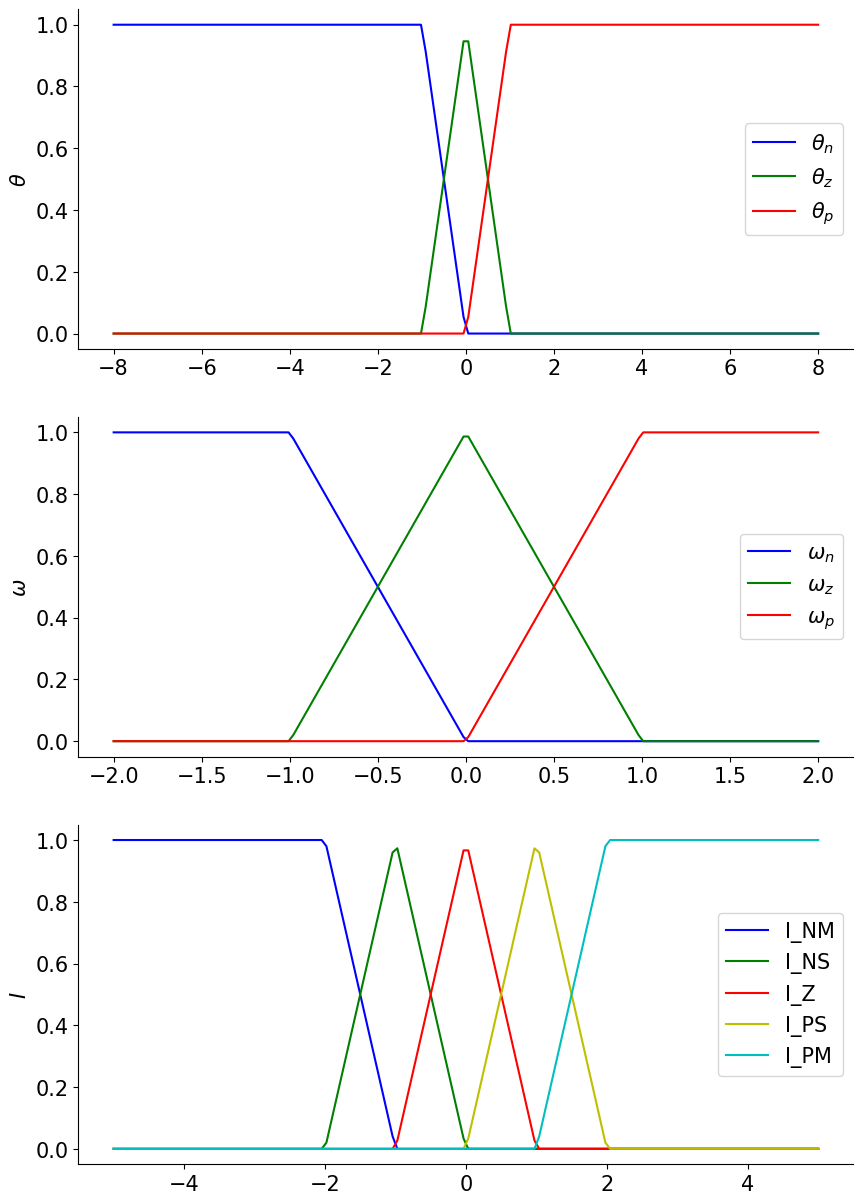

In [27]:
# Let's visualize the membership function defined by the fuzzy sets.
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(10, 15))

ax0.plot(theta, theta_neg, 'b', linewidth=1.5, label=r'$\theta_n$')
ax0.plot(theta, theta_zero, 'g', linewidth=1.5, label=r'$\theta_z$')
ax0.plot(theta, theta_pos, 'r', linewidth=1.5, label=r'$\theta_p$')
#ax0.set_title(r'$\theta$')
ax0.set_ylabel(r'$\theta$')
ax0.legend()

ax1.plot(omega, omega_neg, 'b', linewidth=1.5, label=r'$\omega_n$')
ax1.plot(omega, omega_zero, 'g', linewidth=1.5, label=r'$\omega_z$')
ax1.plot(omega, omega_pos, 'r', linewidth=1.5, label=r'$\omega_p$')
#ax1.set_title(r'$\omega$')
ax1.set_ylabel(r'$\omega$')
ax1.legend()


ax2.plot(current, current_neg_medium, 'b', linewidth=1.5, label='I_NM')
ax2.plot(current, current_neg_small, 'g', linewidth=1.5, label='I_NS')
ax2.plot(current, current_zero, 'r', linewidth=1.5, label='I_Z')
ax2.plot(current, current_pos_small, 'y', linewidth=1.5, label='I_PS')
ax2.plot(current, current_pos_medium, 'c', linewidth=1.5, label='I_PM')
#ax2.set_title(r'$i$')
ax2.set_ylabel(r'$I$')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


plt.show()

### **Rule definition**

The rule base of the system consists in the follwing set:

- if theta is zero and omega is zero then current is zero;
- if theta is zero and omega is neg then current is pos_small;
- if theta is zero and omega is pos then current is neg_small;
- if theta is pos and omega is zero then current is neg_small;
- if theta is pos and omega is pos then current is neg_medium;
- if theta is pos and omega is neg then current is zero;
- if theta is neg and omega is zero then current is pos_small;
- if theta is neg and omega is pos then current is zero;
- if theta is neg and omega is neg then current is pos_medium.

In [28]:
rules = ['if theta is zero and omega is zero then current is zero',
            'if theta is zero and omega is neg then current is pos_small',
            'if theta is zero and omega is pos then current is neg_small',
            'if theta is pos and omega is zero then current is neg_small',
            'if theta is pos and omega is pos then current is neg_medium',
            'if theta is pos and omega is neg then current is zero',
            'if theta is neg and omega is zero then current is pos_small',
            'if theta is neg and omega is pos then current is zero',
            'if theta is neg and omega is neg then current is pos_medium']

### **Quantum fuzzy system**

#### Inizialization

In [29]:
# Let's inizialize the quantum fuzzy system with the input and output variable and relative fuzzy sets and the set of rules.
qfie = FE.QuantumFuzzyEngine(verbose=False)

qfie.input_variable(name='theta', range=theta)
qfie.input_variable(name='omega', range=omega)
qfie.output_variable(name='current', range=current)

qfie.add_input_fuzzysets(var_name='theta', set_names=['neg', 'zero', 'pos'], sets=[theta_neg, theta_zero, theta_pos])
qfie.add_input_fuzzysets(var_name='omega', set_names=['neg', 'zero', 'pos'], sets=[omega_neg, omega_zero, omega_pos])
qfie.add_output_fuzzysets(var_name='current', set_names=['neg_medium', 'neg_small', 'zero', 'pos_small', 'pos_medium'],
                            sets=[current_neg_medium, current_neg_small, current_zero, current_pos_small, current_pos_medium])
qfie.set_rules(rules)

To obtain the control surface of QFIE, it is used to fire the rules in 100 different input combinations. In this problem the values of the input variables is defined by the output value of the previous run. The 100 outputs obtained are collected in a list which will be used at the end of the notebook to plot the control surface.


Due to the fact that the input values are determined by the previous output, it can happen that the value for the input could be putside the universe of discourse, so we need to implement a function which calculates the new values for the input variables and check for the domain constraints.

In [30]:
def BoundaryContraint(theta, omega):
     
    # I have to be sure that the input values are inside the universe of disclosure.
    if omega > 2 :
        omega_new = omega % 2
    elif omega <-2 :
        omega_new = omega % (-2)
    else:
         omega_new = omega # in case the omega value is already inside the boundaries I simply return the value (same for theta).

    if theta > 8 :
        theta_new = theta % 8
    elif theta <-8 :
        theta_new = theta % (-8)
    else:
         theta_new = theta 

    return(theta_new, omega_new)


def recomputeAngle(current, theta, omega, g, t):
        
        # Calculate the new input values:
        l = 12
        tau = 100
        m = 1
        
        if g == True:
            theta_new = theta + omega *t + ((3* tau*100/(l*l))*current-(3*32/2)*cos(theta*pi/4)) *(t*t/2)
            omega_new = omega + ((3*tau*100/(l*l))*current-(3*32/2)*cos(theta*pi/4)) * t
        else: 
            theta_new = theta + omega *t + ((3* tau/(l*l))*current) *(t*t/2)
            omega_new = omega + ((3*tau/(l*l))*current) * t
        
        theta_new, omega_new = BoundaryContraint(theta_new, omega_new)
            
        return(theta_new, omega_new)

## **Control surface**
I want to build the control surface of the inverse pendulum. So I need to apply the fuzzy system to different values of the input variables. Each time I save the output value for that input combination and at the end I can plot the control surface with these values. 
I will build the control surface in three different case: 
- 1) considering a quantum system without noise
- 2) considering a quantum system in which is simulated the Mumbai noise
- 3) considering one different quantum system for each possible value of the output. In each system is simulated the Mumbai noise.

Let's build the control surface without considering the noise

In [31]:
# T = 20 # number of evaluation
# t = 0.05 # time step (this means that the new values for theta and w will be after 0.05 sec from the previous ones)

theta = -2
omega = 0

g = False # this means if I'm considering or not the acceleration gravity.

theta_list, omega_list = [t for t in np.linspace(-8, 8, 10)], [w for w in np.linspace(-2, 2, 10)]
f_quantum = []
for t in theta_list:
    for w in omega_list:
        qfie.build_inference_qc({'theta':t, 'omega':w}, draw_qc=False)
        f_quantum.append(qfie.execute(1000, plot_histo=False)[0])


Text(0.5, 0, 'current')

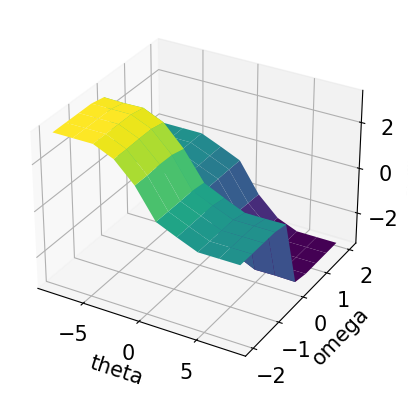

In [32]:
X, Y, = theta_list, omega_list
plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10), np.linspace(np.min(Y),np.max(Y),10))
Z_q = np.zeros_like(plotx)

counter = 0
for i in range(len(theta_list)):
    for j in range(len(omega_list)):
        Z_q[i,j]=f_quantum[counter]
        counter+=1

zfig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(plotx, ploty, Z_q, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)
ax.set_xlabel('theta')
ax.set_ylabel('omega')
ax.set_zlabel('current')

### MUMBAI NOISE

In [33]:
f_quantum_noise = []

for t in theta_list:
    for w in omega_list:
        qfie.build_inference_qc({'theta':t, 'omega':w}, draw_qc=True, filename='qc_plot.png')
        f_quantum_noise.append(qfie.execute(1000, plot_histo=False,  backend=FakeMumbai())[0])


Text(0.5, 0, 'current')

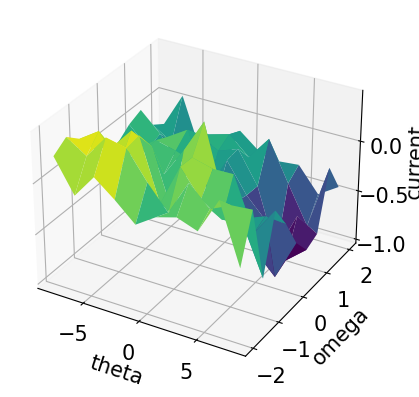

In [34]:
counter = 0
Z_noise = np.zeros_like(plotx)


for i in range(len(theta_list)):
    for j in range(len(omega_list)):
        Z_noise[i,j]=f_quantum_noise[counter]
        counter+=1

zfig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(plotx, ploty, Z_noise, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)
ax.set_xlabel('theta')
ax.set_ylabel('omega')
ax.set_zlabel('current')

### DISTRIBUTED SYSTEM

In [35]:
f_quantum_distributed = []

for t in theta_list:
    for w in omega_list:
        qfie.build_inference_qc({'theta':t, 'omega':w}, distributed=True, draw_qc=True, filename='qc_distributed_plto.png')
        f_quantum_distributed.append(qfie.execute(1000, plot_histo=False,  backend=FakeMumbai())[0])


Text(0.5, 0, 'current')

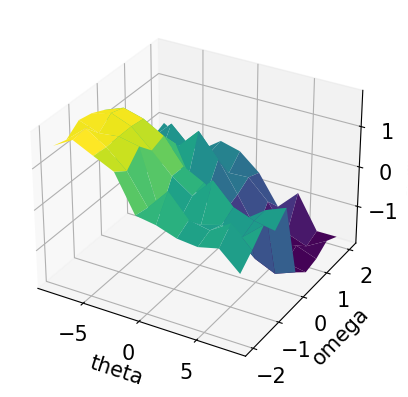

In [36]:
Z_d = np.zeros_like(plotx)

counter = 0

for i in range(len(theta_list)):
    for j in range(len(omega_list)):
        Z_d[i,j]=f_quantum_distributed[counter]
        counter+=1

zfig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(plotx, ploty, Z_d, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)
ax.set_xlabel('theta')
ax.set_ylabel('omega')
ax.set_zlabel('current')

### Compare the results
We will use a metric for observing how much the mumbai noise and the distributed systems are different from the ideal one (in which the noise is zero).

In [38]:
from sklearn.metrics import mean_squared_error
from math import sqrt

MSE_1 = mean_squared_error(Z_q, Z_noise)
RMSE_1 = sqrt(MSE_1)

MSE_2 = mean_squared_error(Z_q, Z_d)
RMSE_2 = sqrt(MSE_2)

print('RMSE for Mumbai noise system: ', RMSE_1)
print('RMSE for distributed system: ', RMSE_2)


RMSE for Mumbai noise system:  1.876932885291811
RMSE for distributed system:  1.1550522361150943


## **Evolution of the pendulum**
I want to study how the pendulum is changing depending on the new current calculated by the fuzzy system. So at each iteration I use as input variables omega and theta calculated with the last value of current obtained.
First I apply the quantum fuzzy system without considering the noise of a real quantum system.

First let's set the input parameters.

In [7]:
T = 600 #number of calls to QFIE
t = 0.01 # time step
theta_0 = -2 #initial angle of the pendulum
omega_0 = 0 #initial radial velocity of the pendulum

g = True # if True the gravity is considered, while if False, g = 0.

Now let's apply the fuzzy quantum system. At each iteration I calculate the value for the current depending on the fuzzy system. Then I update the value for theta and omega and I repeat the process T times.

### WITHOUT NOISE

In [8]:
# In the following variable will be saved all the inputs values that are evaluated
theta_set = [theta_0]
omega_set = [omega_0]

output_points = []

theta = theta_0
omega = omega_0
# Now we can apply the quantum system

for i in range(T):
    qfie.build_inference_qc({'theta':theta, 'omega':omega}, draw_qc=True)

    current = qfie.execute(1000, plot_histo=False)[0] # the execute function returns the crisp output of the system.

    output_points.append(current)

    theta, omega = recomputeAngle(current, theta, omega, g, t)

    theta_set.append(theta)
    omega_set.append(omega)


# the last element of theta_set and omega_set is the value for the inputs that is not used to calculate the next current because the maximum number of iteration is reached. So I must eliminate the last value:
theta_set.pop()
omega_set.pop()

1.1831243902520203

### MUMBAI NOISE

At this point the generated QC can be executed with the execute method. If not backend is specified then the qc is running by using the Qiskit local QasmSimulator. Any backend can be specified and used. As an example the following execution is carried out by using the noisy FakeMumbai() simulator.

In [9]:

# In the following variable will be saved all the inputs values that are evaluated
theta_set_noise = [theta_0]
omega_set_noise = [omega_0]

output_points_noise = []

theta = theta_0
omega = omega_0
# Now we can apply the quantum system

for i in range(T):
    qfie.build_inference_qc({'theta':theta, 'omega':omega}, draw_qc=True)

    current_noise = qfie.execute(n_shots=1000,  backend=FakeMumbai())[0] # the execute function returns the crisp output of the system.

    output_points_noise.append(current_noise)

    theta, omega = recomputeAngle(current_noise, theta, omega, g, t)

    theta_set_noise.append(theta)
    omega_set_noise.append(omega)


# the last element of theta_set_noise and omega_set_noise is the value for the inputs that is not used to calculate the next current because the maximum number of iteration is reached. So I must eliminate the last value:
theta_set_noise.pop()
omega_set_noise.pop()

0.4017298416239983

### DISTRIBUTED NOISE
Here the inference process is distributed over more quantum circuits, one for each possible consequent of the system. This is used for avoiding that the noise will propagate through the system too much. Indeed, rules with different consequent are indipendent and so they can be splitted in different circuits.

By running the execute method the quantum circuits will be executed and the outputs aggregated in order to obtain the crisp output value. If not backend is specified, then all the quantum circuits will be simulated by means of the noiseless QasmSimulator.

In [10]:
# In the following variable will be saved all the inputs values that are evaluated
theta_set_distributed = [theta_0]
omega_set_distributed = [omega_0]

output_points_distributed = []

theta = theta_0
omega = omega_0
# Now we can apply the quantum system

for i in range(T):
    qfie.build_inference_qc({'theta':theta, 'omega':omega}, distributed=True, draw_qc=True)

    current_distributed = qfie.execute(n_shots=1000,  backend=FakeMumbai())[0] # the execute function returns the crisp output of the system.

    output_points_distributed.append(current_distributed)

    theta, omega = recomputeAngle(current_distributed, theta, omega, g, t)

    theta_set_distributed.append(theta)
    omega_set_distributed.append(omega)


# the last element of theta_set_distributed and omega_set_distributed is the value for the inputs that is not used to calculate the next current because the maximum number of iteration is reached. So I must eliminate the last value:
theta_set_distributed.pop()
omega_set_distributed.pop()

0.7571212145236554

In [11]:
#Let's save all the output for avoiding running again the code

# theta = open('theta.txt', 'w')
# omega = open('omega.txt', 'w')
# theta_n = open('theta_noise.txt', 'w')
# omega_n = open('omega_noise.txt', 'w')
# theta_d = open('theta_distributed.txt', 'w')
# omega_d = open('omega_distributed.txt', 'w')

# for i in range(len(theta_set)):
#     theta.write(str(theta_set))
#     omega.write(str(omega_set))


#     theta_n.write(str(theta_set_noise))
#     omega_n.write(str(omega_set_noise))


#     theta_d.write(str(theta_set_distributed))
#     omega_d.write(str(omega_set_distributed))

# theta.close()
# omega.close()
# theta_n.close()
# omega_n.close()
# theta_d.close()
# omega_d.close()

In [12]:
np.savetxt('omegas.txt', (omega_set, omega_set_noise, omega_set_distributed))
np.savetxt('thetas.txt', (theta_set, theta_set_noise, theta_set_distributed))

### COMPARING THE RESULTS

In [13]:
# theta = open('theta.txt', 'r')
# omega = open('omega.txt', 'r')
# theta_n = open('theta_noise.txt', 'r')
# omega_n = open('omega_noise.txt', 'r')
# theta_d = open('theta_distributed.txt', 'r')
# omega_d = open('omega_distributed.txt', 'r')

# theta_set = theta.read()
# theta_set_noise = theta_n.read()
# theta_set_distributed = theta_d.read()
# omega_set = omega.read()
# omega_set_noise = omega_n.read()
# omega_set_distributed = omega_d.read()

# theta.close()
# omega.close()
# theta_n.close()
# omega_n.close()
# theta_d.close()
# omega_d.close()

By running the following cell it is possible to plot the trends of theta and omega controlled by QFIE.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


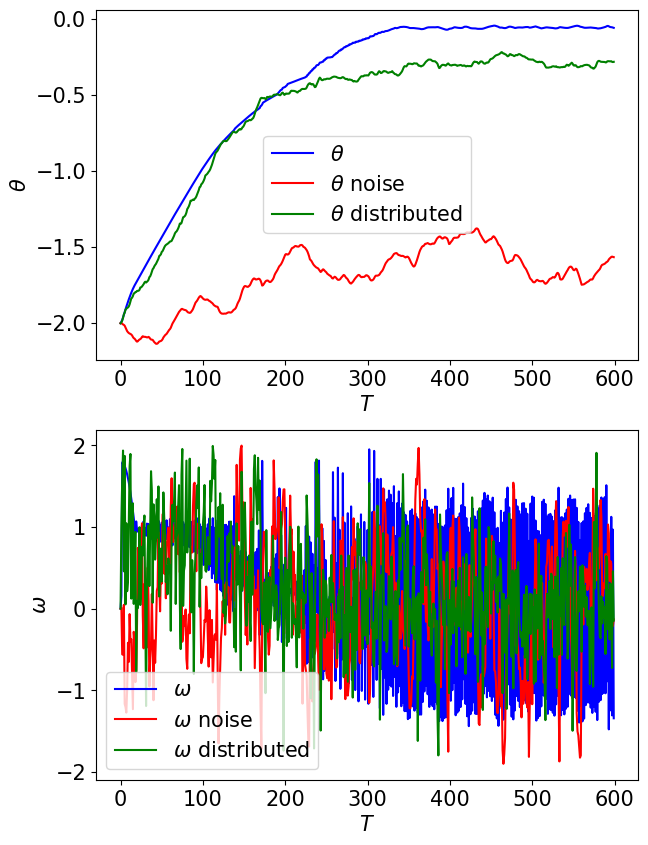

In [24]:
%pylab inline

fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(7, 10))
# axo = plt.figure()

ax0.plot(theta_set, color='b', label=r'$\theta$')
ax0.plot(theta_set_noise, color='r', label=r'$\theta$ noise')
ax0.plot(theta_set_distributed, color='g', label=r'$\theta$ distributed')


ax0.set_ylabel(r'$\theta$')
ax0.set_xlabel(r'$T$')
ax0.legend()

ax1.plot(omega_set, color='b', label=r'$\omega$')
ax1.plot(omega_set_noise, color='r', label=r'$\omega$ noise')
ax1.plot(omega_set_distributed, color='g', label=r'$\omega$ distributed')


ax1.set_ylabel(r'$\omega$')
ax1.set_xlabel(r'$T$')
ax1.legend()

plt.show()

Moreover, the following animation shows the pendulum controlled by the quantum fuzzy inference engine over the time set. 

In [15]:
# conda install -c conda-forge ffmpeg

%matplotlib notebook

fig = plt.figure(figsize=(5, 5), facecolor='w')
ax = fig.add_subplot(1, 1, 1)

plt.rcParams['font.size'] = 15
t_i=[i for i in range(T)]
lns = []

for i in range(T):
    ln, = ax.plot([0, sin(theta_set[i])], [0, cos(theta_set[i])],
                  color='k', lw=2, label='Quantum')
    
    ln_noise, = ax.plot([0, sin(theta_set_noise[i])], [0, cos(theta_set_noise[i])],
                  color='r', lw=2, label='Noise')
    
    ln_distributed, = ax.plot([0, sin(theta_set_distributed[i])], [0, cos(theta_set_distributed[i])],
                  color='g', lw=2, label='Distributed')
    tm = ax.text(-1, 0.9, 'time = %.01f s' % (t_i[i]*t))
    lns.append([ln, ln_noise, ln_distributed, tm])


ax.set_aspect('equal', 'datalim')
ax.legend([ln, ln_noise, ln_distributed],['quantum','noise','distributed'], fontsize = 'x-small')
ax.grid()
ani = animation.ArtistAnimation(fig, lns, interval=50)

plt.rcParams['animation.html'] = 'html5'
ani

<IPython.core.display.Javascript object>